# Student-t location



In [ ]:
import sys
sys.path.insert(0, "..")

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import jax.random as random

from validation import run_single_comparison

## Parameters

In [ ]:
n = 10
k = 1.0
mu_true = 2.0
T_gibbs = 10000
T_kde = 50000
T_fulldata = 10000
burnin = 1000
seed = 0
cache_dir = "../cache"

# Prior: N(prior_mean, prior_std^2). Change prior_std to modify prior variance.
prior_mean = 0.0
prior_std = 3.0
# KDE bandwidth: "scott", "silverman", or a float (e.g. 0.001 for Student-t heavy tails).
kde_bw_method = "silverman"
bw_method = "scott"
# Gibbs RW proposal: std of the Random Walk for mu and for z (x-update). Tune to get acceptance ~20-40%.
proposal_std_mu = 0.5
proposal_std_z = 0.3
base_params = {"prior_mean": prior_mean, "prior_std": prior_std, "kde_bw_method": kde_bw_method,
              "proposal_std_mu": proposal_std_mu, "proposal_std_z": proposal_std_z}

## Run Gibbs, KDE reference, and full-data MH

In [ ]:
key = random.PRNGKey(seed)
out = run_single_comparison(
    "student",
    key,
    n,
    mu_true=mu_true,
    T_gibbs=T_gibbs,
    T_kde=T_kde,
    T_fulldata=T_fulldata,
    burnin=burnin,
    verbose=True,
    cache_dir=None,
    seed_hint=seed,
    base_params=base_params,
    k=k,
)

  Running Gibbs (student, T=50000)...


Gibbs (Student):  19%|█▉        | 9475/50000 [01:01<04:21, 155.13it/s]


KeyboardInterrupt: 

In [ ]:
out["data"]

array([ 1.8576839 , -1.15140517,  4.0735552 , -0.41015369,  1.59254914,
        1.87156629,  4.29977515,  1.4353081 ,  4.95926727,  3.27529556])

## Summary: means and variances

In [ ]:
mle = out["mle"]
print(f"Data: n={n}, true mu={mu_true}, MLE={mle:.4f}")
print()
print("Posterior given MLE (p(mu | MLE)):")
print(f"  Gibbs  mean = {out['gibbs_mean']:.4f}  variance = {out['gibbs_variance']:.6f}")
print(f"  KDE    mean = {out['kde_mean']:.4f}  variance = {out['kde_variance']:.6f}")
print(f"  Variance ratio (Gibbs/KDE): {out['gibbs_variance'] / out['kde_variance']:.4f}")
if out.get('kde_posterior_integral') is not None:
    print(f"  KDE 1D validation (∫ post): {out['kde_posterior_integral']:.6f}  (expect 1.0)")
acc = out.get("gibbs_acceptance", {})
if acc:
    print()
    print("Gibbs acceptance rates:")
    if "mu" in acc:
        print(f"  mu (parameter):   {acc['mu']:.2%}")
    if "pair" in acc:
        print(f"  pair (x update):  {acc['pair']:.2%}")
    if "z" in acc:
        print(f"  z (x update):     {acc['z']:.2%}")
print()
print("Posterior given full data (p(mu | x)):")
print(f"  MH     mean = {out['full_data_mean']:.4f}  variance = {out['full_data_variance']:.6f}")
print(f"  Info loss  Var(mu|MLE) / Var(mu|x) = {out['info_loss_ratio']:.4f}")
if "fulldata_mu_acceptance_rate" in out:
    print(f"  MH mu acceptance: {out['fulldata_mu_acceptance_rate']:.2%}")

Data: n=10, true mu=2.0, MLE=1.9426

Posterior given MLE (p(mu | MLE)):
  Gibbs  mean = 1.6495  variance = 1.506747
  KDE    mean = 1.8428  variance = 0.471470
  Variance ratio (Gibbs/KDE): 3.1959
  KDE 1D validation (∫ post): 1.000000  (expect 1.0)

Gibbs acceptance rates:
  mu (parameter):   71.94%
  pair (x update):  100.00%
  z (x update):     60.99%

Posterior given full data (p(mu | x)):
  MH     mean = 2.0540  variance = 0.342596
  Info loss  Var(mu|MLE) / Var(mu|x) = 1.3762
  MH mu acceptance: 70.99%


## Overlay: densities of the three posteriors

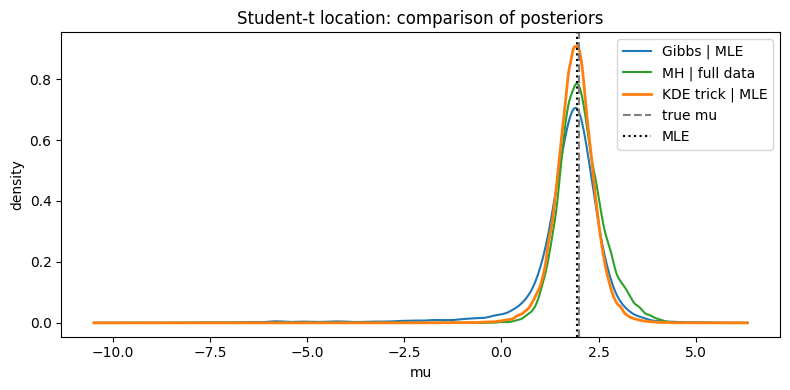

In [ ]:
mu_gibbs = out["mu_chain_post_burnin"]
mu_fulldata = out["mu_chain_fulldata"][burnin:]
kde_pdf = out["kde_posterior_pdf"]

lo = min(mu_gibbs.min(), mu_fulldata.min()) - 0.5
hi = max(mu_gibbs.max(), mu_fulldata.max()) + 0.5
mu_grid = np.linspace(lo, hi, 500)
kde_vals = np.maximum(kde_pdf(mu_grid), 1e-20)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
kde_gibbs = gaussian_kde(mu_gibbs, bw_method=bw_method)
kde_fulldata = gaussian_kde(mu_fulldata, bw_method=bw_method)
ax.plot(mu_grid, kde_gibbs(mu_grid), color="C0", label="Gibbs | MLE")
ax.plot(mu_grid, kde_fulldata(mu_grid), color="C2", label="MH | full data")
ax.plot(mu_grid, kde_vals, color="C1", lw=2, label="KDE trick | MLE")
ax.axvline(mu_true, color="gray", ls="--", label="true mu")
ax.axvline(mle, color="black", ls=":", label="MLE")
ax.set_xlabel("mu")
ax.set_ylabel("density")
ax.legend()
ax.set_title("Student-t location: comparison of posteriors")
plt.tight_layout()
plt.show()

## How the KDE trick works

1. **Simulate MLE at theta=0**: draw many samples x ~ p(x|theta=0), compute MLE for each; you get samples from p(MLE | theta=0).
2. **Fit a KDE** on these MLE samples; the KDE approximates the density of MLE when theta=0.
3. **Location family**: p(MLE | theta) = p(MLE - theta | 0), so the likelihood at parameter value mu is **KDE(mle_observed - mu)** (not KDE(mu)).
4. **Posterior** (unnormalized): prior(mu) * likelihood(mu) = prior(mu) * KDE(mle_observed - mu). Normalize over mu to get p(mu | MLE).

## Trace plots (Gibbs and full-data MH)

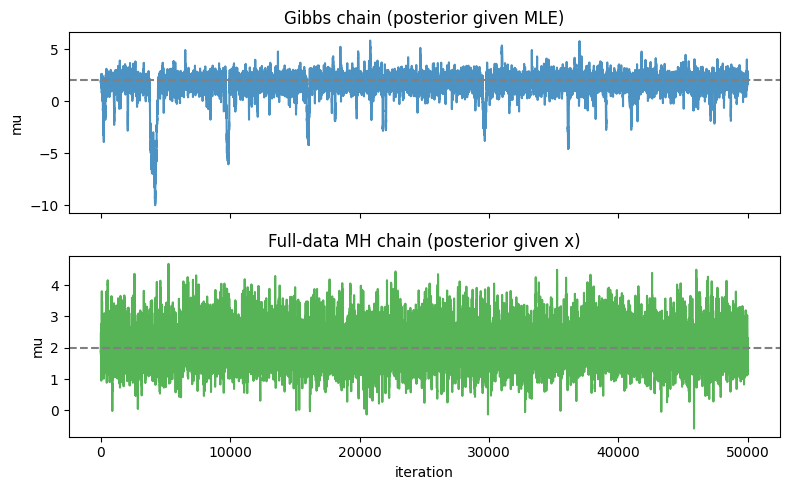

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
axes[0].plot(out["mu_chain_gibbs"], alpha=0.8)
axes[0].set_ylabel("mu")
axes[0].set_title("Gibbs chain (posterior given MLE)")
axes[0].axhline(mu_true, color="gray", ls="--")
axes[1].plot(out["mu_chain_fulldata"], alpha=0.8, color="C2")
axes[1].set_ylabel("mu")
axes[1].set_xlabel("iteration")
axes[1].set_title("Full-data MH chain (posterior given x)")
axes[1].axhline(mu_true, color="gray", ls="--")
plt.tight_layout()
plt.show()